In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import diff_register.im_process as imp
import skimage.io as sio
import diff_classifier.aws as aws
%matplotlib inline

In [2]:
rfolder = 'microglia'
lfolder = 'data'
fname = 'mglia_small'
ext = 'tif'
rfile = '{}/{}.{}'.format(rfolder, fname, ext)
lfile = '{}/{}.{}'.format(lfolder, fname, ext)
file = '{}.{}'.format(fname, ext)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


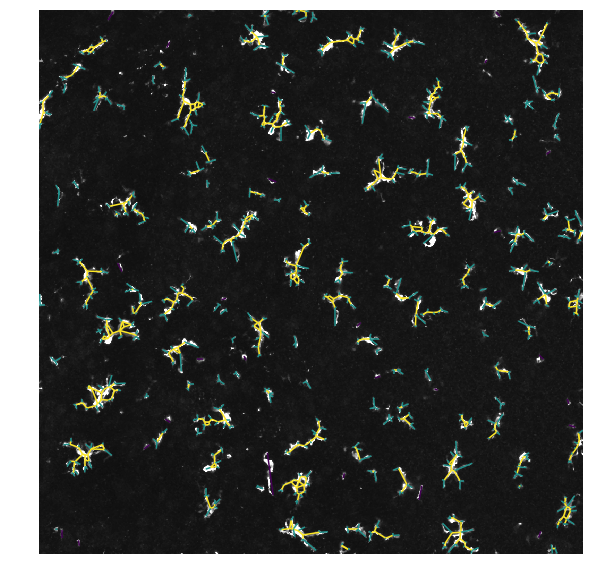

In [3]:
skeleton0, branch_data_short, nbranches, short_image, props = imp.skeleton_image(lfolder, file, show=True)

In [4]:
def mglia_features(props, branch_data_short):
    X = np.zeros((len(props)))
    Y = np.zeros((len(props)))
    perimeter = np.zeros((len(props)))
    areas = np.zeros((len(props)))
    eccentricity = np.zeros((len(props)))
    inertia_tensor = [0]*len(props)
    label = [0]*len(props)
    max_intensity = np.zeros((len(props)))
    mean_intensity = np.zeros((len(props)))
    moments = [0]*len(props)
    solidity = np.zeros((len(props)))
    #total_processes = np.zeros((len(props)))
    #avg_p_length = np.zeros((len(props)))
    #main_process = np.zeros((len(props)))

    #properties that can be found from sklearn.measure.regionprops
    counter = 0
    for item in props:
        X[counter] = item.centroid[0]
        Y[counter] = item.centroid[1]
        perimeter[counter] = item.perimeter
        areas[counter] = item.area
        eccentricity[counter] = item.eccentricity
        inertia_tensor[counter] = item.inertia_tensor
        label[counter] = item.label
        #max_intensity[counter] = item.max_intensity
        #mean_intensity[counter] = item.mean_intensity
        moments[counter] = item.moments
        solidity[counter] = item.solidity
        counter = counter + 1
        
    #properties associated with processes as found from skan
    mglia = branch_data_short['skeleton-id'].max()
    nbranches = []
    avg_p_length = []
    main_process = []
    
    xs = []
    ys = []

    ncount = 0
    for i in branch_data_short['skeleton-id'].unique():
        bcount = branch_data_short[branch_data_short['skeleton-id']==i]['skeleton-id'].count()
        bavg = np.mean(branch_data_short[branch_data_short['skeleton-id']==i]['branch-distance'])
        blong = np.max(branch_data_short[branch_data_short['skeleton-id']==i]['branch-distance'])
        xcoord = np.mean([np.mean(branch_data_short[branch_data_short['skeleton-id']==i]['img-coord-0-0']), 
                         np.mean(branch_data_short[branch_data_short['skeleton-id']==i]['img-coord-1-0'])])
        xs.append(xcoord)
        ycoord = np.mean([np.mean(branch_data_short[branch_data_short['skeleton-id']==i]['img-coord-0-1']), 
                         np.mean(branch_data_short[branch_data_short['skeleton-id']==i]['img-coord-1-1'])])
        ys.append(ycoord)
        nbranches.append(bcount)
        avg_p_length.append(bavg)
        main_process.append(blong)
        
    nbranches_ord = [0]*len(nbranches)
    avg_p_length_ord = [0]*len(nbranches)
    main_process_ord = [0]*len(nbranches)

    for i in range(0, len(xs)):
        #print(xs[i], ys[i])
        skel_id = i
        min_function = np.square(xs[i] - X)+np.square(ys[i] - Y)
        mglia_id = np.argmin(min_function)
        nbranches_ord[mglia_id] = nbranches[skel_id]
        avg_p_length_ord[mglia_id] = avg_p_length[skel_id]
        main_process_ord[mglia_id] = main_process[skel_id]
        #print(mglia_id)
        #print(np.min(min_function))

    features = pd.DataFrame({ 'X' : X,
                              'Y' : Y,
                              'perimeter' : perimeter,
                              'area' : areas,
                              'eccentricity' : eccentricity,
                              'inertia_tensor' : inertia_tensor,
                              'label' : label,
                              #'max intensity' : max_intensity,
                              #'mean intensity' : mean_intensity,
                              'moments' : moments,
                              'solidity' : solidity,
                              'total_branches' : nbranches_ord,
                              'average_branch' : avg_p_length_ord,
                              'main_branch' : main_process_ord
                            })
    
    return features

In [5]:
features = mglia_features(props, branch_data_short)

In [ ]:
features

In [6]:
def features_hist(features, feature, bin_size=100, bin_range=5000):
    xlabel = "Microglia {} (pixels)".format(feature)
    ylabel = "Count"

    nbins = bin_range/bin_size + 1
    test_bins = np.linspace(0, bin_range, nbins)
    dist = features[feature]
    
    histogram, test_bins = np.histogram(dist, bins=test_bins)

    # Plot_general_histogram_code
    avg = np.mean(dist)
    fig = plt.figure(figsize=(16, 6))

    plt.rc('axes', linewidth=2)
    plot = histogram
    bins = test_bins
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:])/2
    bar = plt.bar(center, plot, align='center', width=width)
    plt.axvline(avg)
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    plt.show()

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


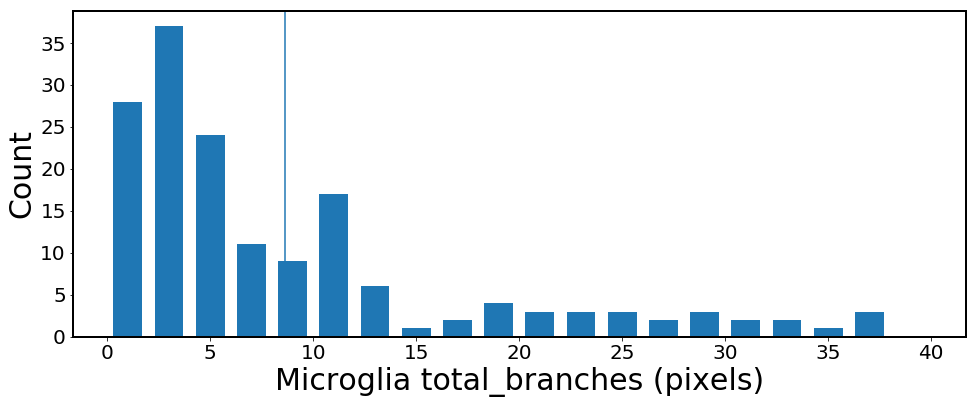

In [7]:
features_hist(features, 'total_branches', bin_size=2, bin_range=40)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


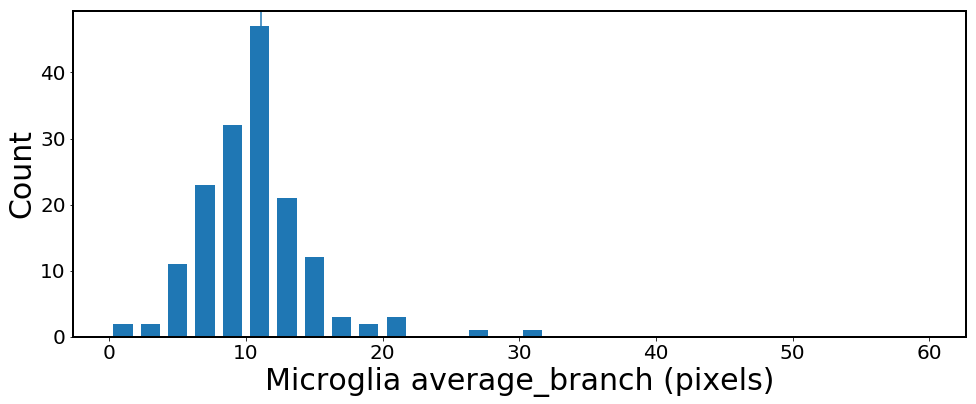

In [8]:
features_hist(features, 'average_branch', bin_size=2, bin_range=60)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


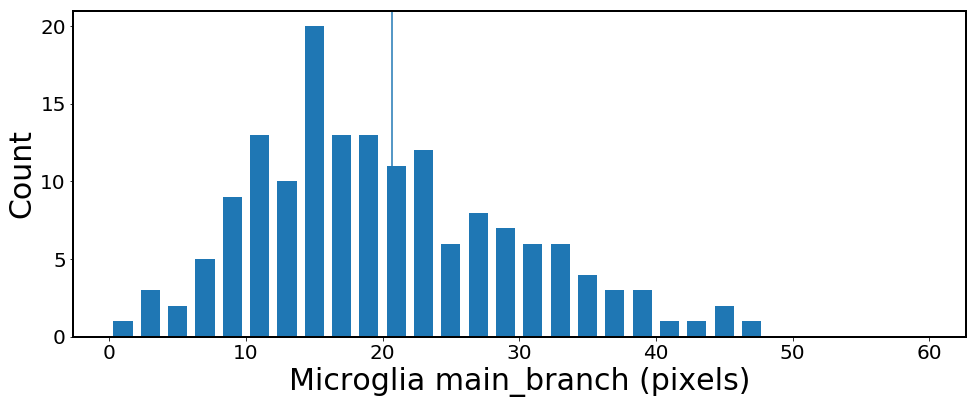

In [9]:
features_hist(features, 'main_branch', bin_size=2, bin_range=60)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


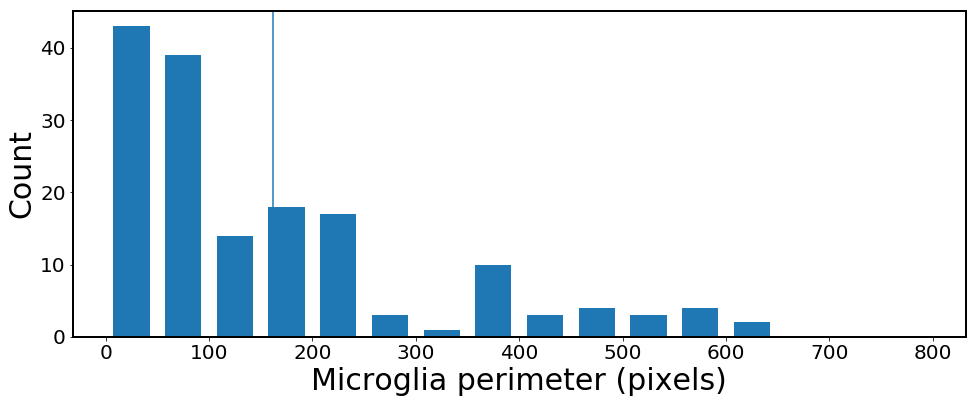

In [10]:
features_hist(features, 'perimeter', bin_size=50, bin_range=800)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


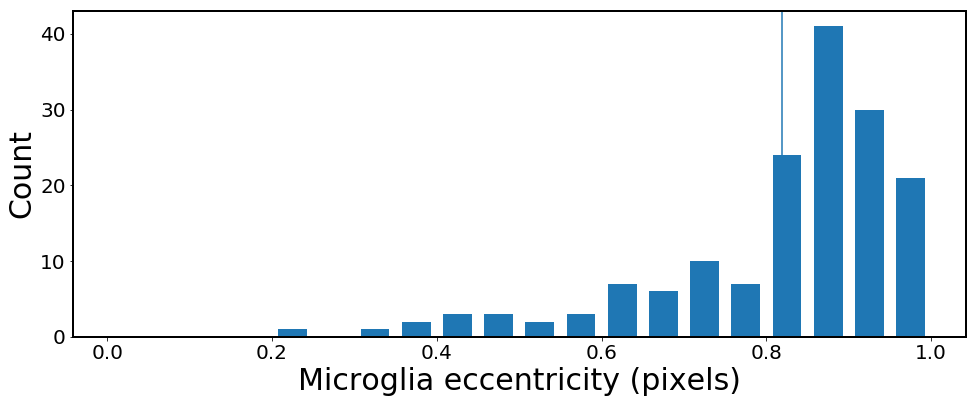

In [11]:
features_hist(features, 'eccentricity', bin_size=0.05, bin_range=1)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


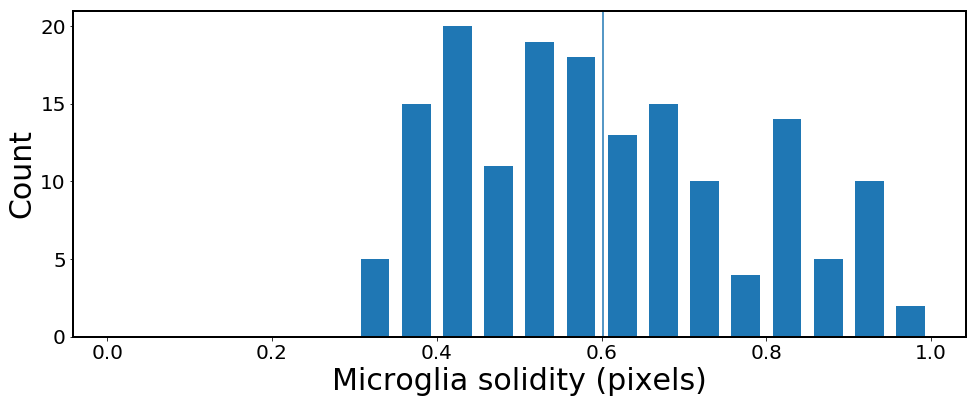

In [12]:
features_hist(features, 'solidity', bin_size=0.05, bin_range=1)

In [ ]:
bin_size = 100
bin_range = 5000
xlabel = "Microglia Area (pixels)"
ylabel = "Count"

nbins = bin_range/bin_size + 1
test_bins = np.linspace(0, bin_range, nbins)
dist = features['area']

In [ ]:
histogram, test_bins = np.histogram(dist, bins=test_bins)

# Plot_general_histogram_code
avg = np.mean(dist)
fig = plt.figure(figsize=(16, 6))

plt.rc('axes', linewidth=2)
plot = histogram
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2
bar = plt.bar(center, plot, align='center', width=width)
plt.axvline(avg)
plt.xlabel(xlabel, fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)

In [ ]:
plt.show()